In [23]:
from src.dataloading import get_trained_unet1, get_preprocessed_data_loaders
from IPython.display import display, clear_output
import matplotlib.pyplot as plt

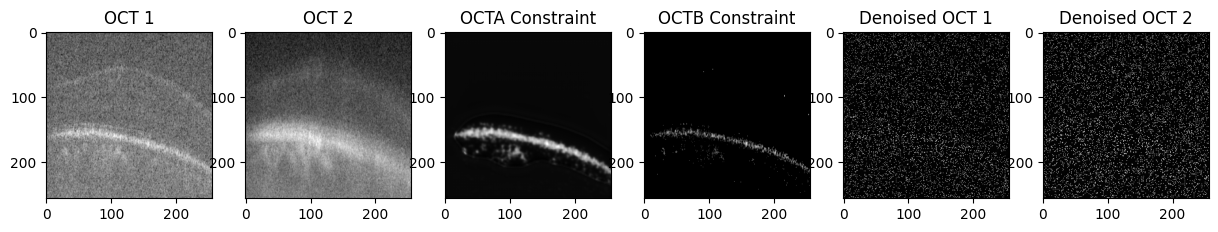

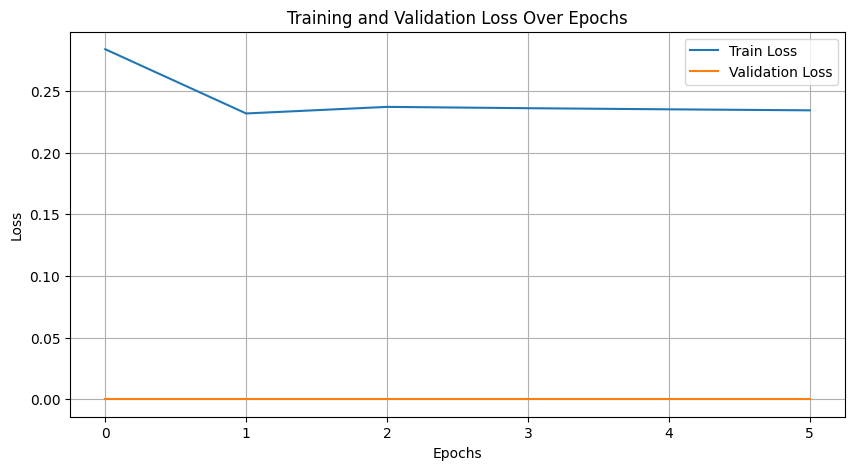

In [ ]:
import torch
from src.visualise import plot_loss

def visualize_stage2(oct1, oct2, octa_constraint, octb_constraint, denoised_oct1, denoised_oct2):
    clear_output(wait=True)  # Clears previous outputs, ensuring only the latest visualizations appear
    
    fig, ax = plt.subplots(1, 6, figsize=(15, 5))
    ax[0].imshow(oct1, cmap='gray')
    ax[0].set_title('OCT 1')
    ax[1].imshow(oct2, cmap='gray')
    ax[1].set_title('OCT 2')
    ax[2].imshow(octa_constraint, cmap='gray')
    ax[2].set_title('OCTA Constraint')
    ax[3].imshow(octb_constraint, cmap='gray')
    ax[3].set_title('OCTB Constraint')
    ax[4].imshow(denoised_oct1, cmap='gray')
    ax[4].set_title('Denoised OCT 1')
    ax[5].imshow(denoised_oct2, cmap='gray')
    ax[5].set_title('Denoised OCT 2')
    
    plt.show()

class SSN2VStage2:
    def __init__(self, unet_model, device, alpha=1.0, mask_percentage=0.1):
        self.model = unet_model
        self.device = device
        self.alpha = alpha
        self.mask_percentage = mask_percentage
        self.model.train()
        
    def train_step(self, oct1, oct2, octa_constraint, octb_constraint):
        # Normalize inputs if needed
        oct1 = oct1.float() / 255.0 if oct1.max() > 1 else oct1
        oct2 = oct2.float() / 255.0 if oct2.max() > 1 else oct2
        octa_constraint = octa_constraint.float() / 255.0 if octa_constraint.max() > 1 else octa_constraint
        octb_constraint = octb_constraint.float() / 255.0 if octb_constraint.max() > 1 else octb_constraint
        
        # Apply N2V masking to both OCT images
        mask1 = self.create_n2v_mask(oct1)
        mask2 = self.create_n2v_mask(oct2)
        
        # Forward pass
        denoised_oct1, _ = self.model(oct1 * mask1)
        denoised_oct2, _ = self.model(oct2 * mask2)
        
        # Compute Noise2Void losses
        loss_n2v1 = self.compute_n2v_loss(denoised_oct1, oct1, mask1)
        loss_n2v2 = self.compute_n2v_loss(denoised_oct2, oct2, mask2)
        
        # Compute OCTA constraint loss
        computed_octa = self.compute_octa(denoised_oct1, denoised_oct2)
        loss_octa = self.alpha * torch.mean((computed_octa - octa_constraint) ** 2)
        
        # Compute OCT B-scan constraint loss (NEW)
        loss_octb = self.alpha * torch.mean((denoised_oct1 - octb_constraint) ** 2 + (denoised_oct2 - octb_constraint) ** 2)

        # Total loss
        total_loss = loss_n2v1 + loss_n2v2 + loss_octa + loss_octb  # Add loss_octb

        return total_loss, denoised_oct1, denoised_oct2


    
    def create_n2v_mask(self, x):
        """Create Noise2Void blind-spot mask more efficiently"""
        B, C, H, W = x.shape
        mask = torch.ones((B, C, H, W), device=self.device)
        n_pixels = int(self.mask_percentage * H * W)
        
        indices = torch.rand((B, H*W), device=self.device).argsort(dim=1)[:, :n_pixels]
        rows = indices // W
        cols = indices % W
        
        for b in range(B):
            mask[b, :, rows[b], cols[b]] = 0
        return mask
    
    def compute_n2v_loss_(self, pred, target, mask):
        """Compute Noise2Void loss for masked pixels"""
        return torch.mean((pred * (1 - mask) - target * (1 - mask)) ** 2)
    
    def compute_n2v_loss(self, pred, target, mask):
        """Compute Noise2Void loss for masked pixels with proper normalization"""
        masked_diff = (pred - target) * (1 - mask)
        return torch.sum(masked_diff ** 2) / torch.sum(1 - mask)
    
    @torch.no_grad()
    def compute_octa(self, oct1, oct2):
        """Compute OCTA more efficiently"""
        diff_squared = torch.pow(oct1 - oct2, 2)
        sum_squared = torch.pow(oct1, 2) + torch.pow(oct2, 2)
        return diff_squared / (sum_squared + 1e-8)

def train_ssn2v(ssn2v, train_loader, optimizer, num_epochs, visualize_every=50):
    scaler = torch.cuda.amp.GradScaler()
    train_loss = []
    val_loss = []
    
    # Learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=5, verbose=True
    )
    
    best_loss = float('inf')
    patience_counter = 0
    patience_limit = 20  # Early stopping patience
    
    for epoch in range(num_epochs):
        epoch_loss = 0
        num_batches = 0
        
        ssn2v.model.train()  # Ensure model is in training mode
        
        for batch_idx, batch in enumerate(train_loader):
            # Extract data according to the new format
            oct1 = batch['raw'].to(ssn2v.device)
            oct2 = batch['fused'].to(ssn2v.device)
            octa_constraint = batch['original_constraint'].to(ssn2v.device)
            octb_constraint = batch['new_constraint'].to(ssn2v.device)

            
            if oct1.dim() == 3:
                oct1 = oct1.unsqueeze(1)  # Add channel dimension if missing
                oct2 = oct2.unsqueeze(1)
                octa_constraint = octa_constraint.unsqueeze(1)
            
            optimizer.zero_grad(set_to_none=True)
            
            with torch.cuda.amp.autocast():
                loss, denoised_oct1, denoised_oct2 = ssn2v.train_step(oct1, oct2, octa_constraint, octb_constraint)

            
            # Gradient clipping to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(ssn2v.model.parameters(), max_norm=1.0)
            
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
            epoch_loss += loss.item()
            num_batches += 1
            
            # Visualization and logging
            if batch_idx % visualize_every == 0:
                with torch.no_grad():
                    visualize_stage2(
                        oct1[0][0].cpu(),
                        oct2[0][0].cpu(),
                        octa_constraint[0][0].cpu(),
                        octb_constraint[0][0].cpu(),
                        denoised_oct1.detach().cpu()[0][0],
                        denoised_oct2.detach().cpu()[0][0],
                        
                    )
                    plot_loss(train_loss, val_loss)
                    
                    print(f'Batch {batch_idx}, Loss: {loss.item():.4f}')
                    # Optional: log additional metrics
                    print(f'Image shapes - OCT1: {oct1.shape}, OCT2: {oct2.shape}')
                    print(f'Value ranges - OCT1: [{oct1.min():.3f}, {oct1.max():.3f}], '
                          f'OCT2: [{oct2.min():.3f}, {oct2.max():.3f}]')
        
        avg_epoch_loss = epoch_loss / num_batches
        train_loss.append(avg_epoch_loss)
        
        # Learning rate scheduling
        scheduler.step(avg_epoch_loss)
        
        # Early stopping check
        if avg_epoch_loss < best_loss:
            best_loss = avg_epoch_loss
            patience_counter = 0
            # Save both model and optimizer states
            torch.save({
                'epoch': epoch,
                'model_state_dict': ssn2v.model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': best_loss,
            }, r'C:\temp\stage2\best_model.pth')
        else:
            patience_counter += 1
            if patience_counter >= patience_limit:
                print(f'Early stopping triggered after {epoch + 1} epochs')
                break
        
        print(f'Epoch {epoch+1}, Loss: {avg_epoch_loss:.4f}')
        
        # Ensure validation loss list matches training loss list length
        if len(val_loss) < len(train_loss):
            val_loss.append(0)
    
    return train_loss, val_loss

img_size = 256

train_loader, val_loader = get_preprocessed_data_loaders(
    base_path='C:/temp/stage1',
    patient_id=0,  # For patient 0
    img_size=img_size,  # Adjust to your needs
    batch_size=1   # Adjust based on your GPU memory
)

sample = next(iter(train_loader))

sample.keys()

device, model, criterion, optimizer = get_trained_unet1(img_size)

ssn2v_trainer = SSN2VStage2(model, device)

train_ssn2v(ssn2v_trainer, train_loader, optimizer, num_epochs=20)